# 图片分类

1. [介绍](#介绍)
2. [预处理](#预处理)
  1. [权限和环境变量](#权限和环境变量)
  2. [准备数据](#准备数据)
3. [图像分类模型的微调](#图像分类模型的微调)
  1. [训练参数](#训练参数)
  2. [训练](#训练)
4. [部署模型](#部署模型)
  1. [创建模型](#创建模型)
  2. [推理](#推理)
    1. [创建终端节点配置](#创建终端节点配置) 
    2. [创建终端节点](#创建终端节点) 
    3. [Perform inference](#Perform-inference) 
    4. [Clean up](#Clean-up)

## 介绍
[参看原文](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/imageclassification_caltech/Image-classification-lst-format.ipynb)  
欢迎来到图像分类算法训练的端到端示例。在这个演示中，我们将在迁移学习模式下使用Amazon-sagemaker图像分类算法来微调预先训练的模型（根据imagenet数据进行训练），以学习对新数据集进行分类。

我们需要通过一些先决步骤来设置环境，这些步骤包括权限、配置等。

## 预处理
### 权限和环境变量
设置到AWS服务的链接和身份验证。包含三个部分：

* 用于向学习和托管访问数据的角色。这将从用于启动笔记本的角色自动获取

* 用于存储训练数据和模型的S3

* Amazon sagemaker图像分类docker image，无需更改

In [1]:
%%time
import boto3
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

#role = get_execution_role()
role = "arn:aws-cn:iam::315505707008:role/service-role/AmazonSageMaker-ExecutionRole-20200430T124235"

bucket='junzhong' # customize to your bucket

training_image = get_image_uri(boto3.Session().region_name, 'image-classification')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


CPU times: user 438 ms, sys: 47.8 ms, total: 486 ms
Wall time: 484 ms


### 准备数据
这里没有使用原文的256 dataset，采用的是kaggle的[猫狗分类](https://www.kaggle.com/c/dogs-vs-cats/data)，已下载到国内。

In [3]:
import os
import urllib.request

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

download('https://nowfox.s3.cn-northwest-1.amazonaws.com.cn/data/cat-vs-dog-1000.zip')
!unzip -q cat-vs-dog-1000.zip
rm cat-vs-dog-1000.zip

# Tool for creating lst file
#download('https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py')
download('https://nowfox.s3.cn-northwest-1.amazonaws.com.cn/software/im2rec.py')

In [ ]:
%%bash

mkdir -p cat-vs-dog-val
for i in cat-vs-dog-1000/*; do
    c=`basename $i`
    mkdir -p cat-vs-dog-val/$c
    for j in `ls $i/*.jpg | shuf | head -n 100`; do
        mv $j cat-vs-dog-val/$c/
    done
done

#比原文多了一个test数据集
mkdir -p cat-vs-dog-test
for i in cat-vs-dog-1000/*; do
    c=`basename $i`
    mkdir -p cat-vs-dog-test/$c
    for j in `ls $i/*.jpg | shuf | head -n 100`; do
        mv $j cat-vs-dog-test/$c/
    done
done

mv cat-vs-dog-1000 cat-vs-dog-train

In [7]:
%%bash
python im2rec.py --list --recursive cat-vs-dog-train cat-vs-dog-train/
python im2rec.py --list --recursive cat-vs-dog-val cat-vs-dog-val/

cat 0
dog 1
cat 0
dog 1


In [9]:
!head -n 3 ./cat-vs-dog-train.lst > example.lst
f = open('example.lst','r')
lst_content = f.read()
print(lst_content)

38	0.000000	cat/cat.161.jpg
500	1.000000	dog/dog.405.jpg
188	0.000000	cat/cat.382.jpg



In [10]:
# Four channels: train, validation, train_lst, and validation_lst
s3train = 's3://{}/image-classification/cat-vs-dog/train/'.format(bucket)
s3validation = 's3://{}/image-classification/cat-vs-dog/validation/'.format(bucket)
s3train_lst = 's3://{}/image-classification/cat-vs-dog/train_lst/'.format(bucket)
s3validation_lst = 's3://{}/image-classification/cat-vs-dog/validation_lst/'.format(bucket)

# upload the image files to train and validation channels
!aws s3 cp cat-vs-dog-train $s3train --recursive --quiet
!aws s3 cp cat-vs-dog-val $s3validation --recursive --quiet

# upload the lst files to train_lst and validation_lst channels
!aws s3 cp cat-vs-dog-train.lst $s3train_lst --quiet
!aws s3 cp cat-vs-dog-val.lst $s3validation_lst --quiet

## 图像分类模型的微调
### 训练参数

In [11]:
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
# For this training, we will use 18 layers
num_layers = 18
# we need to specify the input image shape for the training data
image_shape = "3,224,224"
# we also need to specify the number of training samples in the training set
num_training_samples = 15240
# specify the number of output classes
num_classes = 257
# batch size for training
mini_batch_size = 128
# number of epochs
epochs = 6
# learning rate
learning_rate = 0.01
# report top_5 accuracy
top_k = 5
# resize image before training
resize = 256
# period to store model parameters (in number of epochs), in this case, we will save parameters from epoch 2, 4, and 6
checkpoint_frequency = 2
# Since we are using transfer learning, we set use_pretrained_model to 1 so that weights can be 
# initialized with pre-trained weights
use_pretrained_model = 1

### 训练

In [18]:
%%time
import time
import boto3
from time import gmtime, strftime


s3 = boto3.client('s3')
# create unique job name 
job_name_prefix = 'sagemaker-imageclassification-notebook'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, job_name_prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p3.2xlarge",
        "VolumeSizeInGB": 50
    },
    "EnableManagedSpotTraining": True,
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate),
        "top_k": str(top_k),
        "resize": str(resize),
        "checkpoint_frequency": str(checkpoint_frequency),
        "use_pretrained_model": str(use_pretrained_model)    
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000,
        "MaxWaitTimeInSeconds": 360000
    },
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3train,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3validation,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        },
        {
            "ChannelName": "train_lst",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3train_lst,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation_lst",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3validation_lst,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: sagemaker-imageclassification-notebook-2020-09-07-07-10-39

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://junzhong/image-classification/cat-vs-dog/train/', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 4.43 ms, sys: 88 µs, total: 4.52 ms
Wall time: 3.96 ms


In [19]:
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress
Training job ended with status: Completed


In [20]:
training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info['TrainingJobStatus']
print("Training job ended with status: " + status)
print (training_info)

Training job ended with status: Completed
{'TrainingJobName': 'sagemaker-imageclassification-notebook-2020-09-07-07-10-39', 'TrainingJobArn': 'arn:aws-cn:sagemaker:cn-northwest-1:315505707008:training-job/sagemaker-imageclassification-notebook-2020-09-07-07-10-39', 'ModelArtifacts': {'S3ModelArtifacts': 's3://junzhong/sagemaker-imageclassification-notebook/output/sagemaker-imageclassification-notebook-2020-09-07-07-10-39/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'checkpoint_frequency': '2', 'epochs': '6', 'image_shape': '3,224,224', 'learning_rate': '0.01', 'mini_batch_size': '128', 'num_classes': '257', 'num_layers': '18', 'num_training_samples': '15240', 'resize': '256', 'top_k': '5', 'use_pretrained_model': '1'}, 'AlgorithmSpecification': {'TrainingImage': '387376663083.dkr.ecr.cn-northwest-1.amazonaws.com.cn/image-classification:1', 'TrainingInputMode': 'File', 'MetricDefinitions': [{'Name': 'train:accuracy', 'Regex

If you see the message,

> `Training job ended with status: Completed`

then that means training sucessfully completed and the output model was stored in the output path specified by `training_params['OutputDataConfig']`.

You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab.

## 部署模型

### 创建模型

In [32]:
%%time
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
model_name="image-classification-model" + timestamp
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

hosting_image = get_image_uri(boto3.Session().region_name, 'image-classification')

primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


image-classification-model-2020-09-07-08-25-21
s3://junzhong/sagemaker-imageclassification-notebook/output/sagemaker-imageclassification-notebook-2020-09-07-07-10-39/output/model.tar.gz
arn:aws-cn:sagemaker:cn-northwest-1:315505707008:model/image-classification-model-2020-09-07-08-25-21
CPU times: user 125 ms, sys: 16.9 ms, total: 142 ms
Wall time: 538 ms


### 推理

#### 创建终端节点配置

In [33]:
from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.t2.medium',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: sagemaker-imageclassification-notebook-epc--2020-09-07-08-25-29
Endpoint configuration arn:  arn:aws-cn:sagemaker:cn-northwest-1:315505707008:endpoint-config/sagemaker-imageclassification-notebook-epc--2020-09-07-08-25-29


#### 创建终端节点

In [34]:
%%time
import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: sagemaker-imageclassification-notebook-ep--2020-09-07-08-27-43
EndpointArn = arn:aws-cn:sagemaker:cn-northwest-1:315505707008:endpoint/sagemaker-imageclassification-notebook-ep--2020-09-07-08-27-43
CPU times: user 10.9 ms, sys: 527 µs, total: 11.5 ms
Wall time: 187 ms


Finally, now the endpoint can be created. It may take sometime to create the endpoint...

In [ ]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))
    
try:
    sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
finally:
    resp = sagemaker.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Arn: " + resp['EndpointArn'])
    print("Create endpoint ended with status: " + status)

    if status != 'InService':
        message = sagemaker.describe_endpoint(EndpointName=endpoint_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Endpoint creation did not succeed')

EndpointStatus = Creating


If you see the message,

> `Endpoint creation ended with EndpointStatus = InService`

then congratulations! You now have a functioning inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console.

We will finally create a runtime object from which we can invoke the endpoint.

#### Perform inference
Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.


In [27]:
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker') 

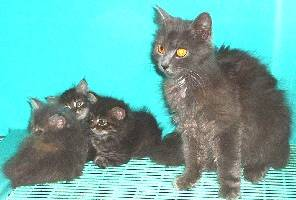

In [29]:
file_name = './cat-vs-dog-test/cat/cat.101.jpg'
# test image
from IPython.display import Image
Image(file_name)  

In [30]:
import json
import numpy as np
with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = ['cat','dog']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

Result: label - cat, probability - 0.9942300319671631


#### Clean up

When we're done with the endpoint, we can just delete it and the backing instances will be released. Uncomment and run the following cell to delete the endpoint and model

In [ ]:
sage.delete_endpoint(EndpointName=endpoint_name)